In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from FCNN import FCNN
from loss_function import CombinedLoss
from train_test2 import train_model
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets, plot_predictions_vs_targets_sr
from visualization import plot_mean_power_spectrum, plot_mean_power_spectrum_sr
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders, prepare_dataloaders_multiVar
from qualitative_eval import mse, r2_score, pearson_corr, first_esr_exceeds_half

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


# Helper Functions

In [3]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

In [4]:
def data_loader(train_data_HF, test_data_HF, train_data_LR, test_data_LR,
                var_LR=['u_relative'], var_HF='heatflux_diff',
                batch_size=32, normalization_type=None, val_split=0.2):
    """
    Prepare train/val/test DataLoaders from high- and low-resolution datasets.

    Args:
        train_data_HF: xarray.Dataset - high-frequency training data (to be split into train/val)
        test_data_HF: xarray.Dataset - high-frequency test data (held out entirely)
        train_data_LR: xarray.Dataset - low-res training data
        test_data_LR: xarray.Dataset - low-res test data
        var_LR: List[str] - list of LR variables to extract
        var_HF: str - HF target variable to extract
        batch_size: int - batch size
        normalization_type: str or None - 'standardization', 'normalization', or None
        val_split: float - fraction of training set to use for validation
        seed: int - random seed for reproducibility

    Returns:
        train_loader, val_loader, test_loader
        HF_test (np.ndarray), LR_test (np.ndarray)
    """

    # ---- Split train_data into training and validation ----
    n_samples = len(train_data_HF.time)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    val_size = int(val_split * n_samples)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    HF_train_ds = train_data_HF.isel(time=train_indices)
    HF_val_ds   = train_data_HF.isel(time=val_indices)
    LR_train_ds = train_data_LR.isel(time=train_indices)
    LR_val_ds   = train_data_LR.isel(time=val_indices)

    # Keep test data separate
    HF_test_ds = test_data_HF
    LR_test_ds = test_data_LR

    print("Train size:", len(HF_train_ds.time))
    print("Val size:", len(HF_val_ds.time))
    print("Test size:", len(HF_test_ds.time))

    # ---- Extract variables ----
    HF_train = getattr(HF_train_ds, var_HF).values
    HF_val   = getattr(HF_val_ds, var_HF).values
    HF_test  = getattr(HF_test_ds, var_HF).values

    def stack_vars(ds, varlist):
        return np.stack([ds[v].values for v in varlist], axis=1)

    LR_train = stack_vars(LR_train_ds, var_LR)
    LR_val   = stack_vars(LR_val_ds, var_LR)
    LR_test  = stack_vars(LR_test_ds, var_LR)

    # ---- Normalize if requested ----
    if normalization_type == 'standardization':
        HF_mean, HF_std = HF_train.mean(), HF_train.std()
        LR_mean = LR_train.mean(axis=(0, 2, 3), keepdims=True)
        LR_std  = LR_train.std(axis=(0, 2, 3), keepdims=True)

        HF_train = (HF_train - HF_mean) / HF_std
        HF_val   = (HF_val   - HF_mean) / HF_std
        HF_test  = (HF_test  - HF_mean) / HF_std

        LR_train = (LR_train - LR_mean) / LR_std
        LR_val   = (LR_val   - LR_mean) / LR_std
        LR_test  = (LR_test  - LR_mean) / LR_std

    elif normalization_type == 'normalization':
        HF_min, HF_max = HF_train.min(), HF_train.max()
        LR_min = LR_train.min(axis=(0, 2, 3), keepdims=True)
        LR_max = LR_train.max(axis=(0, 2, 3), keepdims=True)

        HF_train = (HF_train - HF_min) / (HF_max - HF_min)
        HF_val   = (HF_val   - HF_min) / (HF_max - HF_min)
        HF_test  = (HF_test  - HF_min) / (HF_max - HF_min)

        LR_train = (LR_train - LR_min) / (LR_max - LR_min)
        LR_val   = (LR_val   - LR_min) / (LR_max - LR_min)
        LR_test  = (LR_test  - LR_min) / (LR_max - LR_min)

    # ---- Torch tensors ----
    x_train = torch.tensor(LR_train, dtype=torch.float32)
    y_train = torch.tensor(HF_train, dtype=torch.float32).unsqueeze(1)

    x_val = torch.tensor(LR_val, dtype=torch.float32)
    y_val = torch.tensor(HF_val, dtype=torch.float32).unsqueeze(1)

    x_test = torch.tensor(LR_test, dtype=torch.float32)
    y_test = torch.tensor(HF_test, dtype=torch.float32).unsqueeze(1)

    # ---- Datasets & Loaders ----
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, HF_test, LR_test

# Data Pre-processing

In [5]:
ds_HR_train = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_globalRegions.zarr", engine="zarr", chunks={}) 
ds_LR_train = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR_globalRegions.zarr", engine="zarr", chunks={}) 
ds_HF_train = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_globalRegions.zarr", engine="zarr", chunks={}) 

ds_HR_test = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_globalRegions_Yr3.zarr", engine="zarr", chunks={}) 
ds_LR_test = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR_globalRegions_Yr3.zarr", engine="zarr", chunks={}) 
ds_HF_test = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_globalRegions_Yr3.zarr", engine="zarr", chunks={}) 

In [6]:
# Config choices Abigail chose

input_channels = 6
output_channels = 1
conv_layers = 7
kernel = 5
#init_bound = 0.5
kernel_hidden = 3
activation = "ReLU"
arch = "fcnn"

config={"input_channels":input_channels,
        "output_channels":output_channels,
        "activation":activation,
        "arch":arch,
        "conv_layers":conv_layers,
        "kernel":kernel,
        "kernel_hidden":kernel_hidden}

# Case 1: Training on every 10th data point

In [7]:
model1 = FCNN(config=config)
model1

FCNN(
  (conv): Sequential(
    (0): Conv2d(6, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (10): ReLU()
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

In [8]:
ds_HF_train = ds_HF_train.isel(time=slice(0,len(ds_HF_train.time),10))
ds_HF_test = ds_HF_test.isel(time=slice(0,len(ds_HF_test.time),10))
ds_LR_train = ds_LR_train.isel(time=slice(0,len(ds_LR_train.time),10))
ds_LR_test = ds_LR_test.isel(time=slice(0,len(ds_LR_test.time),10))

In [9]:
var_LR = ['u_relative', 'v_relative', 't_ref', 'surface_temp', 'q_ref', 'slp']
train_loader, val_loader, test_loader, HF_test, LR_test = data_loader(ds_HF_train, ds_HF_test, ds_LR_train, ds_LR_test, var_LR=var_LR, var_HF='heatflux_diff', batch_size=32, normalization_type='standardization')

Train size: 701
Val size: 175
Test size: 438


In [24]:
criterion = nn.L1Loss() 
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model(model1, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_sample10thpts_global.pth',
            n_epochs=2000, patience=30, stop_crit='R2', lr_sched_crit='R2') # n_epochs=2000)

Trainable Parameters: 149569
Epoch 1, Train Loss: 6.581e-01, Val Loss: 5.761e-01, Val R²: 0.1145, Epoch Time: 7.00s
Model saved at epoch 1
Epoch 2, Train Loss: 5.738e-01, Val Loss: 6.418e-01, Val R²: -0.0020, Epoch Time: 6.50s
Model saved at epoch 2
Epoch 3, Train Loss: 5.505e-01, Val Loss: 5.346e-01, Val R²: 0.2122, Epoch Time: 6.52s
Model saved at epoch 3
Epoch 4, Train Loss: 5.373e-01, Val Loss: 5.190e-01, Val R²: 0.2515, Epoch Time: 6.53s
Model saved at epoch 4
Epoch 5, Train Loss: 5.449e-01, Val Loss: 5.588e-01, Val R²: 0.1991, Epoch Time: 6.55s
Model saved at epoch 5
Epoch 6, Train Loss: 5.554e-01, Val Loss: 5.766e-01, Val R²: 0.0409, Epoch Time: 6.58s
Model saved at epoch 6
Epoch 7, Train Loss: 5.439e-01, Val Loss: 5.204e-01, Val R²: 0.2331, Epoch Time: 6.59s
Model saved at epoch 7
Epoch 8, Train Loss: 5.343e-01, Val Loss: 5.198e-01, Val R²: 0.2584, Epoch Time: 6.60s
Model saved at epoch 8
Epoch 9, Train Loss: 5.271e-01, Val Loss: 5.369e-01, Val R²: 0.1957, Epoch Time: 6.62s
Mod

In [10]:
device = torch.device("cuda")
sgs_pred = evaluate_model_sr(model1, device, test_loader, HF_test, './model_sample10thpts_global.pth')
sgs_pred

Loaded model parameters from ./model_sample10thpts_global.pth


array([[[-0.33456674, -0.40763646, -0.41068834, ...,  0.09493414,
          0.20777434,  0.27412525],
        [-0.4613785 , -0.52384806, -0.509484  , ..., -0.0635493 ,
          0.05983366,  0.15180302],
        [-0.47172314, -0.5388885 , -0.5361413 , ...,  0.01647206,
          0.13438742,  0.21999918],
        ...,
        [ 0.41621312, -0.31127706, -0.32927415, ..., -0.7382419 ,
         -0.49445796, -0.31335178],
        [ 0.54410905, -0.20801173, -0.25001156, ..., -0.79394907,
         -0.5321989 , -0.39929384],
        [ 0.27702898, -0.4503266 , -0.4659003 , ..., -0.5329769 ,
         -0.3292472 , -0.1744915 ]],

       [[-0.29637396, -0.29449078, -0.2846545 , ..., -0.19187482,
         -0.17403892, -0.29290706],
        [-0.32560202, -0.3240569 , -0.3085557 , ..., -0.28567988,
         -0.29167697, -0.32780105],
        [-0.11733916, -0.11188792, -0.09408562, ..., -0.10871139,
         -0.10517552, -0.17292103],
        ...,
        [-3.4816556 , -3.4777753 , -3.4927652 , ..., -

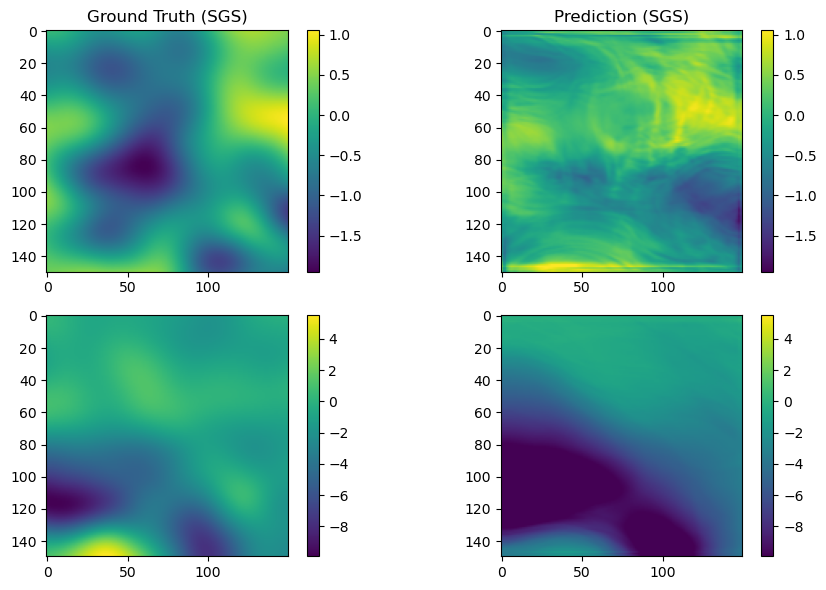

In [11]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=2, cmap='viridis', cbar_shared_lims=True)

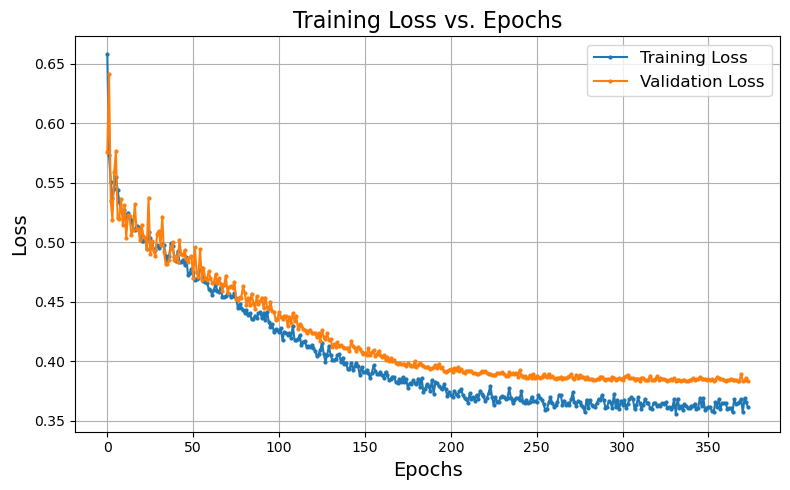

In [27]:
plot_train_val_losses(train_losses, val_losses)

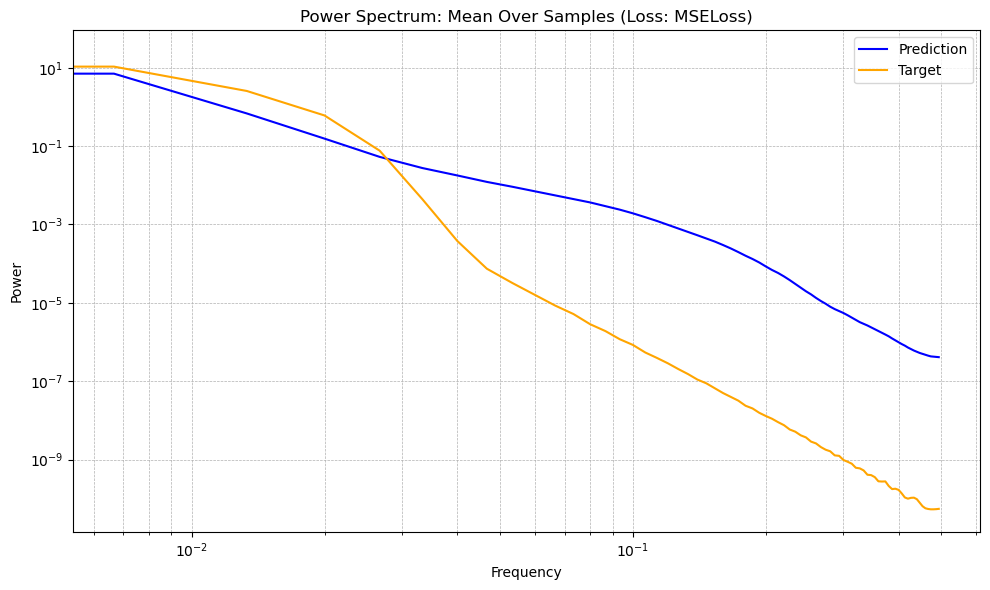

In [12]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6), show_slopes=False)

In [13]:
mse_val = mse(HF_test, sgs_pred)
r = pearson_corr(HF_test, sgs_pred)
r2 = r2_score(HF_test, sgs_pred)
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
print(f"MSE is {mse_val}")
print(f"Pearson correlation coefficient is {r}")
print(f"r2 is {r2}")
print(f"ESR first exceeds half at {k_thresh}")

All frequencies have ESR > 1.0
MSE is 0.46324560046195984
Pearson correlation coefficient is 0.7333399694173767
r2 is 0.5238506197929382
ESR first exceeds half at None


In [14]:
r2_scores_10thptsamp = r2_per_sample(HF_test, sgs_pred)
r2_scores_10thptsamp

array([-2.41624475e-01, -1.68214512e+00,  4.79777813e-01,  7.63436675e-01,
        7.40725040e-01,  6.35423422e-01,  5.54282665e-01,  1.46408737e-01,
        6.17960691e-01,  5.51732183e-02,  7.13178158e-01,  4.82174993e-01,
        4.16472435e-01,  4.14550126e-01,  5.54953933e-01,  5.40317774e-01,
        2.27701545e-01,  1.86452925e-01, -5.22296429e-02,  6.83830917e-01,
        6.43310785e-01,  6.94810033e-01,  5.16452312e-01,  5.22356868e-01,
        3.97756398e-01,  1.97280109e-01,  5.96075416e-01,  6.05194449e-01,
        4.32915807e-01,  7.58001983e-01,  3.72235239e-01,  4.50857341e-01,
        6.24057174e-01,  3.00311625e-01,  1.99374557e-01,  4.30877209e-01,
        8.60129356e-01,  6.67070925e-01,  6.83626056e-01,  7.23277688e-01,
        3.98070037e-01,  7.05642819e-01,  4.78666425e-01,  5.78795075e-01,
        6.93604589e-01,  1.46145463e-01,  4.34473097e-01,  5.91278076e-02,
        3.28141153e-01,  2.46563911e-01,  3.81578922e-01,  5.38470268e-01,
        4.98162746e-01, -

# Case 2: Training on all data

In [15]:
model2 = FCNN(config=config)
model2

FCNN(
  (conv): Sequential(
    (0): Conv2d(6, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (10): ReLU()
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

In [16]:
ds_HR_train = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_globalRegions.zarr", engine="zarr", chunks={}) 
ds_LR_train = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR_globalRegions.zarr", engine="zarr", chunks={}) 
ds_HF_train = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_globalRegions.zarr", engine="zarr", chunks={}) 

ds_HR_test = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_globalRegions_Yr3.zarr", engine="zarr", chunks={}) 
ds_LR_test = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR_globalRegions_Yr3.zarr", engine="zarr", chunks={}) 
ds_HF_test = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_globalRegions_Yr3.zarr", engine="zarr", chunks={}) 

In [17]:
var_LR = ['u_relative', 'v_relative', 't_ref', 'surface_temp', 'q_ref', 'slp']
train_loader, val_loader, test_loader, HF_test, LR_test = data_loader(ds_HF_train, ds_HF_test, ds_LR_train, ds_LR_test, var_LR=var_LR, var_HF='heatflux_diff', batch_size=32, normalization_type='standardization')

Train size: 7008
Val size: 1752
Test size: 4380


In [18]:
criterion = nn.L1Loss() 
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model(model2, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_allpts_global.pth',
            n_epochs=2000, patience=30, stop_crit='R2', lr_sched_crit='R2') # n_epochs=2000)

Trainable Parameters: 149569
Resuming from epoch 268 with best val losses [] and best R2 values [0.9224995374679565, 0.9224122166633606, 0.9226530194282532, 0.9224113821983337, 0.9227003455162048]
Epoch 269, Train Loss: 1.833e-01, Val Loss: 1.610e-01, Val R²: 0.9269, Epoch Time: 68.30s
Best model so far saved to ./model_allpts_global.pth
Epoch 270, Train Loss: 1.844e-01, Val Loss: 1.620e-01, Val R²: 0.9260, Epoch Time: 67.94s
Epoch 271, Train Loss: 1.856e-01, Val Loss: 1.619e-01, Val R²: 0.9261, Epoch Time: 68.04s
Epoch 272, Train Loss: 1.857e-01, Val Loss: 1.627e-01, Val R²: 0.9238, Epoch Time: 67.91s
Epoch 273, Train Loss: 1.859e-01, Val Loss: 1.615e-01, Val R²: 0.9261, Epoch Time: 67.97s
Epoch 274, Train Loss: 1.842e-01, Val Loss: 1.626e-01, Val R²: 0.9243, Epoch Time: 68.06s
Epoch 275, Train Loss: 1.854e-01, Val Loss: 1.615e-01, Val R²: 0.9267, Epoch Time: 68.05s
Epoch 276, Train Loss: 1.848e-01, Val Loss: 1.637e-01, Val R²: 0.9234, Epoch Time: 68.04s
Patience counter: 1/30
Epoch 2

In [18]:
device = torch.device("cuda")
sgs_pred = evaluate_model_sr(model2, device, test_loader, HF_test, './model_allpts_global.pth')
sgs_pred

Loaded model parameters from ./model_allpts_global.pth


array([[[ 0.27874678,  0.2544186 ,  0.31966373, ...,  0.38782895,
          0.39140716,  0.29678693],
        [ 0.2741827 ,  0.2940071 ,  0.30443782, ...,  0.33451563,
          0.31740364,  0.16219126],
        [ 0.38078332,  0.3443382 ,  0.35843042, ...,  0.3143279 ,
          0.36151478,  0.30172583],
        ...,
        [ 0.16177304,  0.07836942, -0.16122504, ..., -0.27588564,
         -0.4196061 , -0.47109824],
        [ 0.5270601 ,  0.4936057 ,  0.2134301 , ..., -0.00986889,
         -0.2008653 , -0.17826149],
        [ 0.33527002,  0.3401851 ,  0.12865473, ..., -0.23142312,
         -0.40452498, -0.38484246]],

       [[ 0.80293936,  0.8076123 ,  0.8187031 , ..., -0.07735814,
          0.01558371, -0.13850217],
        [ 0.6843411 ,  0.70898616,  0.70303845, ..., -0.28193077,
         -0.18022545, -0.3136814 ],
        [ 0.7306087 ,  0.73677546,  0.7432913 , ..., -0.00845135,
          0.1160161 ,  0.01383205],
        ...,
        [ 1.1359164 ,  1.1049961 ,  1.064228  , ...,  

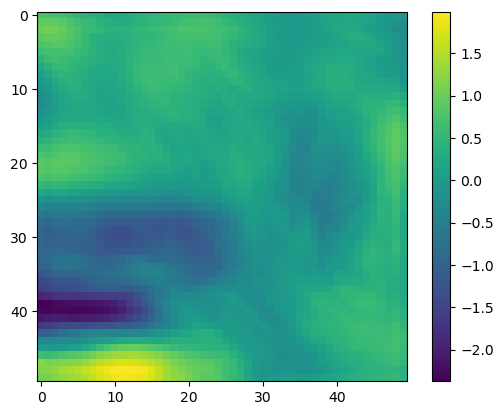

In [42]:
arr = sgs_pred

# Wrap in xarray
sgs_pred_xr = xr.DataArray(
    arr,
    dims=("time", "xt_ocean", "yt_ocean"),
    coords={
        "time": np.arange(sgs_pred.shape[0]),
        "xt_ocean": np.arange(sgs_pred.shape[1]),
        "yt_ocean": np.arange(sgs_pred.shape[2]),
    },
    name="sgs_pred"
)

# Coarsen spatial dims
sgs_pred_xr_coarse0 = sgs_pred_xr.isel(time=1).coarsen(xt_ocean=3, yt_ocean=3, boundary="trim").mean()

plt.imshow(sgs_pred_xr_coarse0, cmap='viridis')
plt.colorbar()

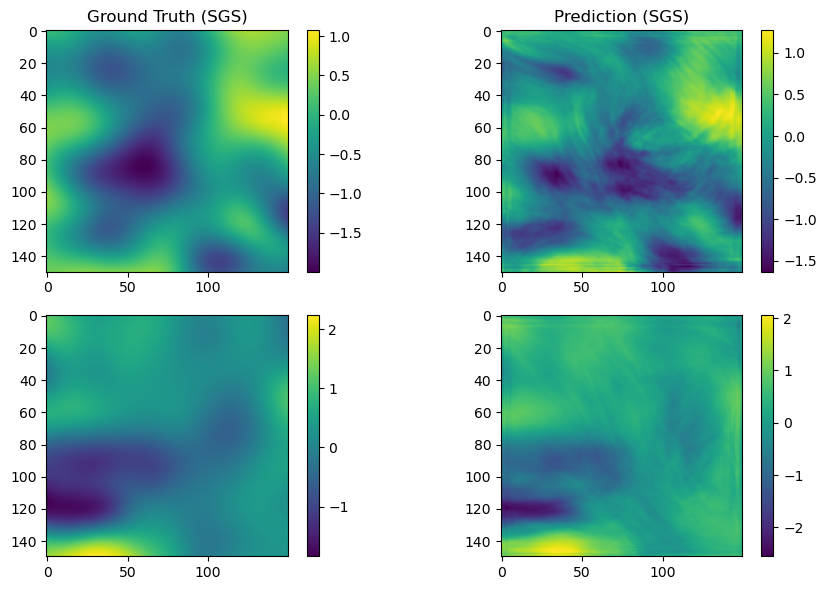

In [19]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=2, cmap='viridis', cbar_shared_lims=False)

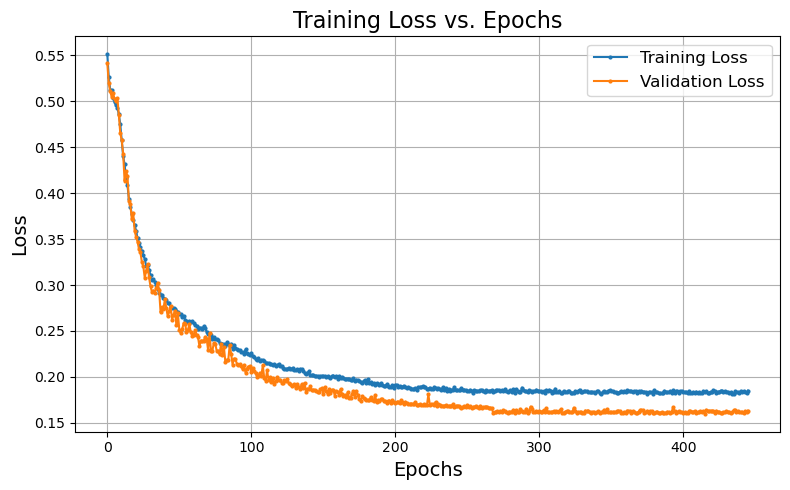

In [21]:
plot_train_val_losses(train_losses, val_losses)

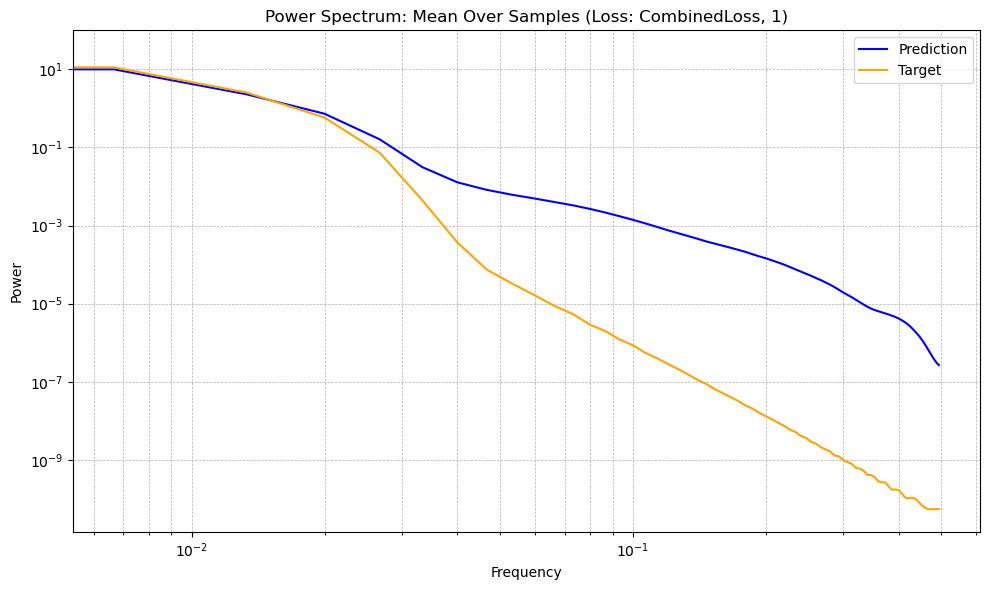

In [20]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="CombinedLoss", alpha_label="1", figsize=(10, 6), show_slopes=False)

In [21]:
mse_val = mse(HF_test, sgs_pred)
r = pearson_corr(HF_test, sgs_pred)
r2 = r2_score(HF_test, sgs_pred)
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
print(f"MSE is {mse_val}")
print(f"Pearson correlation coefficient is {r}")
print(f"r2 is {r2}")
print(f"ESR first exceeds half at {k_thresh}")

All frequencies have ESR > 1.0
MSE is 0.07666600495576859
Pearson correlation coefficient is 0.9623852034281036
r2 is 0.9259461760520935
ESR first exceeds half at None


In [22]:
r2_scores_allpts = r2_per_sample(HF_test, sgs_pred)
r2_scores_allpts

array([0.51297438, 0.92216575, 0.93977773, ..., 0.95784694, 0.94503856,
       0.92073405], shape=(4380,))

# Comparison

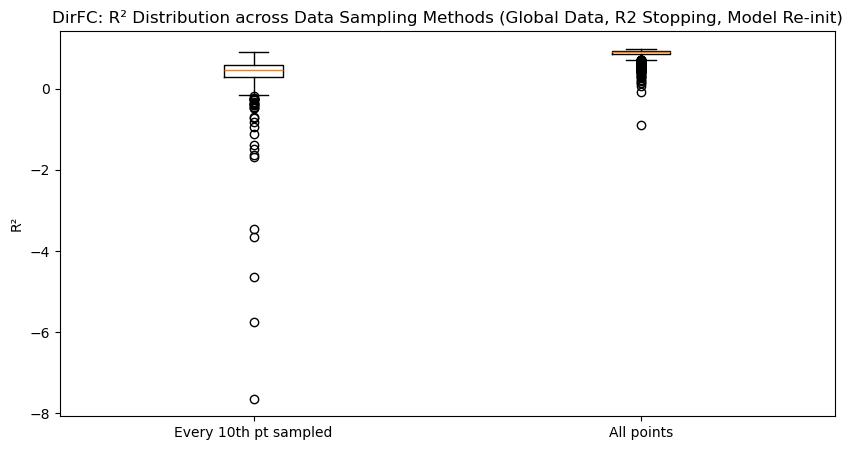

In [28]:
data = [r2_scores_10thptsamp, r2_scores_allpts]

plt.figure(figsize=(10, 5))
plt.boxplot(data, vert=True)  # each array becomes a separate boxplot
plt.xticks([1, 2], ["Every 10th pt sampled", "All points"])  # label each box
plt.ylabel("R²")
plt.title("DirFC: R² Distribution across Data Sampling Methods (Global Data, R2 Stopping, Model Re-init)")
plt.show()

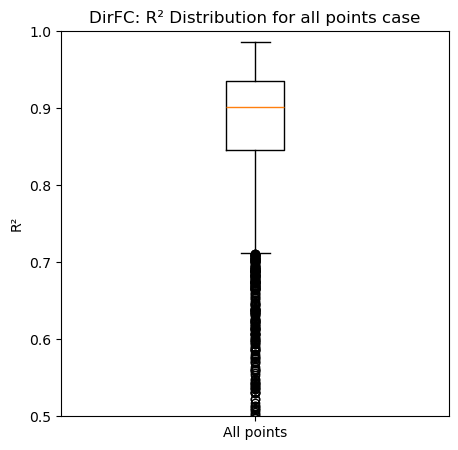

In [27]:
data = [r2_scores_allpts]

plt.figure(figsize=(5, 5))
plt.boxplot(data, vert=True)  # each array becomes a separate boxplot
plt.xticks([1], ["All points"])  # label each box
plt.ylabel("R²")
plt.ylim((0.5,1))
plt.title("DirFC: R² Distribution for all points case")
plt.show()